# Getting Started

In this this notebook, we introduce the core functionalities of `mclearn`. For more information on the package, refer to the [documentation](https://pythonhosted.org/mclearn/) and the [API Reference](https://pythonhosted.org/mclearn/api.html).

In [1]:
import mclearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
%matplotlib inline
plt.style.use('ggplot')

## 1. About the Dataset

There are two ways we can measure objects on the sky. The first option is to obtain a full spectrum. This is expensive but it contains a lot of valuable information. For example astronmers can look at a spectrum and determine what kind of star or galaxy the object is. A cheaper method is to obtain photometric measurments. Here we set up a filter and only allow light from certain wavelengths to go through. We then add up the amount of light (i.e. integrate) and obtain a photometric measurment. For example, below we plot the spectrum of Vega (one of the brighest stars in the sky) and the 5 ugriz photometric filters. Using these five filters, we will end up with five photometric values of Vega, one in each light band. Since now we only have 5 numbers (instead of a spectrum), it's a lot more difficult to manually classify the object. Let's see if machine learning can help us. For more information about the differences between photometry and spectroscopy, [here's](https://physics.stackexchange.com/questions/169734/photometric-surveys-vs-spectroscopic-surveys) a good description on StackExchange.

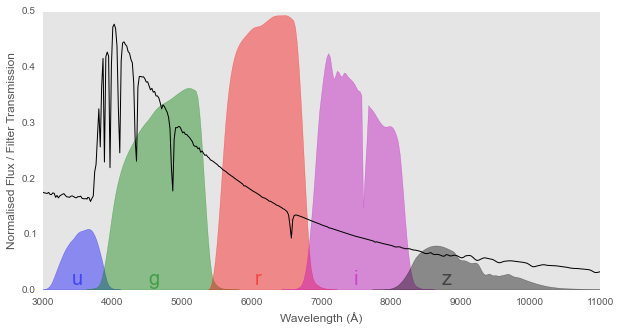

In [2]:
vega_spectrum_url = 'http://www.astro.washington.edu/users/ivezic/DMbook/data/1732526_nic_002.ascii'
ugriz_filter_url = 'http://www.sdss.org/dr7/instruments/imager/filters/%s.dat'

fig = plt.figure(figsize=(10,5))
ax = mclearn.plot_filters_and_spectrum(ugriz_filter_url, vega_spectrum_url)

The <a href="http://www.sdss.org/" target="_blank">Sloan Digital Sky Survey</a> (SDSS) is a comprehensive survey of the northern sky. In this notebook, we will explore a small subset of the survey, namely the photometric measurements and spectroscopic labels of around 2,000 objects in a small section of the sky. Let's submit an SQL query to the Sloan Sky Server to get the dataset.

In [3]:
output = 'data/sdss_small.csv'
sql_query = '''
    SELECT
        p.ra, p.dec,
        CASE s.class WHEN 'GALAXY' THEN 'Galaxy'
                     WHEN 'STAR' THEN 'Star'
                     WHEN 'QSO' THEN 'Quasar'
                     END AS class,
        p.psfMag_u, p.psfMag_g, p.psfMag_r, p.psfMag_i, p.psfMag_z,
        p.petroMag_u, p.petroMag_g, p.petroMag_r, p.petroMag_i, p.petroMag_z,
        p.petroRad_r, extinction_r
    FROM PhotoObj AS p
       JOIN SpecObj AS s ON s.bestobjid = p.objid
    WHERE
       p.psfMag_r < 21 AND
       p.ra BETWEEN 202 AND 207 AND
       p.dec BETWEEN 0 AND 2 '''

mclearn.photometry.fetch_sloan_data(sql_query, output, verbose=True)

Connecting to the server...
Writing to file...
Success!


## 2. Exploratory Analysis

Okay, let's read in the data and see what we have.

In [4]:
sdss = pd.io.parsers.read_csv("data/sdss_small.csv")
sdss.head()

,ra,dec,class,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,petroRad_r,extinction_r
0,205.041772,1.225637,Quasar,22.33957,20.69193,20.60227,20.48185,20.59905,22.64906,20.67106,20.67370,20.55878,20.61250,1.332299,0.064220
1,205.056272,0.496612,Galaxy,24.15581,22.71687,20.99946,19.97933,19.51431,25.93601,22.09508,20.50595,19.45818,18.98700,1.734146,0.081771
2,205.074412,0.882936,Galaxy,23.37353,21.91115,20.22815,19.61556,19.30375,24.58035,21.27997,19.43404,18.75463,18.53402,2.939431,0.076804
3,205.081585,1.416685,Star,18.25325,17.27528,16.88841,16.77056,16.72031,18.29956,17.30037,16.95146,16.83360,16.79116,1.378984,0.064170
4,205.827414,1.799152,Galaxy,24.07808,22.59162,20.83035,20.02864,19.46696,22.87317,21.52034,20.02671,19.02419,18.55864,2.969733,0.067893


The first two columns - ra and dec - are the coordinates of the objects (see the [wiki page](https://en.wikipedia.org/wiki/Equatorial_coordinate_system) for more information). Our target column is called `class` - this can be one of Galaxy, Quasar, or Star. Looking at the distribution of the classes, we can see that the dataset is very unbalanced. We have, for example, five times as many galaxies as stars and quasars.

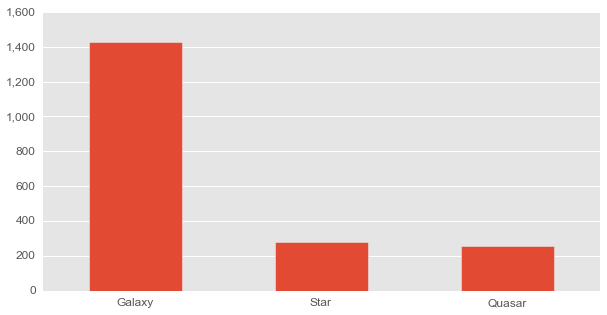

In [5]:
fig = plt.figure(figsize=(10, 5))
ax = mclearn.viz.plot_class_distribution(sdss['class'])

Given this extreme imbalance, we will be mainly using the balanced accuracy rate when reporting the performance of a classifier. To compute this measure, we first define $A_i$, the accuracy rate of class $i$, as:

\begin{align}
       A_i = \dfrac{C_{ii}}{m_i}
\end{align}

where $C$ is the confusion matrix with entry $C_{ij}$ being the
number of objects in class $i$ but have been as class
$j$, and $m_i$ is the number of objects in class $i$.
Before running a classifier, we know nothing of its performance, so we
can assume the accuracy rate follows a flat prior distribution. In
particular, the Beta distribution with parameters
$\alpha = \beta = 1$ (i.e. a uniform distriubtion) seems
appropriate here:

\begin{align}
       A_i \sim Beta(1, 1) \qquad \forall i
\end{align}

Given an accuracy rate $A_i$ for each class $i$, the number
of correct predictions in class $i$ will follow a Binomial
distribution with $A_i$ as the probability of success:

\begin{align}
       \big( C_{ii} \mid A_i \big) \sim Bin\big(m_i, A_i\big)  \qquad \forall i
\end{align}

In Bayesian terms, this is our likelihood. Now we know that with respect
to a Binomial likelihood, the Beta distribution is conjugate to itself.
Thus the posterior distribution of $A_i$ will also be Beta with
parameters:

\begin{align}
       \big( A_i \mid C_{ii} \big) \sim Beta \big( 1 + C_{ii}, 1 + m_i - C_{ii} \big) \qquad \forall i
\end{align}

The (posterior) balanced accuracy rate $A$ can now be defined as the average
of the individual accuracy rates $A_i$:

\begin{align}
       A = \dfrac{1}{k} \sum_i A_i
\end{align}

where $k$ is the number of classes.

When presenting our results, we will often be using the Mollweide projection. Here's the layout of the coordinates, with the red line being the plane of the Milky Way.

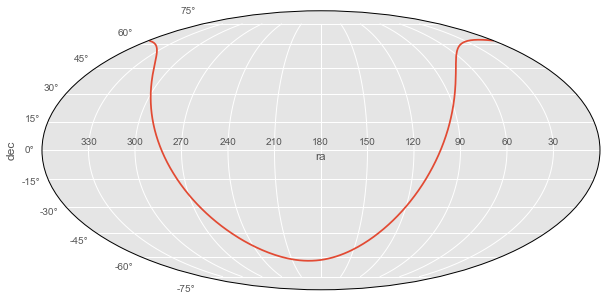

In [6]:
fig = plt.figure(figsize=(10,5))
zero_values = np.zeros(1)
ax = mclearn.viz.plot_hex_map(zero_values, zero_values, axisbg=None, colorbar=False, labels=True)

For example, this is where the objects in our dataset are located in the sky. It's a very small region roughly in the middle. For now, it seems that the map is not very useful. However, when we look at the whole SDSS dataset, being able to plot the results on a map will become quite handy.

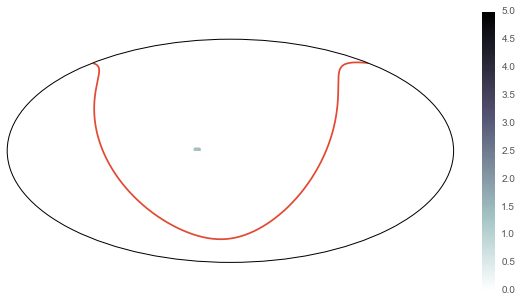

In [7]:
fig = plt.figure(figsize=(10,5))
ax = mclearn.viz.plot_hex_map(sdss['ra'], sdss['dec'], vmax=5)

## 3. Magnitudes, Colours, and Dust

In the datasets, we have 11 features - 5 Petrosian magitudes, 5 PSF magnitudes, and a size measurement. To get a feel of how separated the three classes are, let's use PCA and reduce these 11 features down to 2 dimensions.

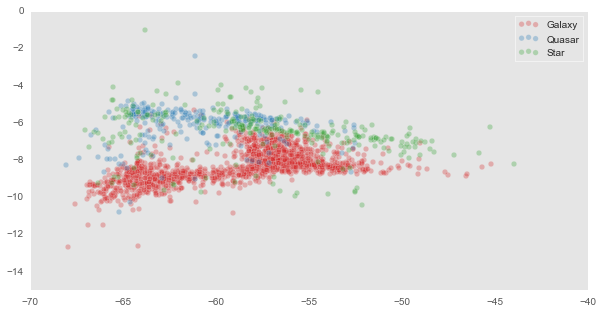

In [8]:
feature_cols = ['psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i', 'psfMag_z', 'petroMag_u',
                'petroMag_g', 'petroMag_r', 'petroMag_i', 'petroMag_z', 'petroRad_r']
target_col = 'class'
classes = ['Galaxy', 'Quasar', 'Star']

pca = PCA(n_components=2)
projection = pca.fit_transform(sdss[feature_cols])
target = np.array(sdss[target_col])

fig = plt.figure(figsize=(10, 5))
ax = mclearn.viz.plot_scatter_with_classes(projection, target, classes, size=30, alpha=0.3, scatterpoints=3)
ax.set_xlim(-70, -40)
ax.set_ylim(-15, 0)
plt.show()

As light travels through space to Earth, some of it get absorbed and scattered by the galactic dust. Light in the higher frequency range is more affected, hence extinction causes an object to become redder. This gives the phenomenon the name 'interstellar reddening'.

The amount of extinction varies across the sky. For example, there is a lot of dust in the Milky Way band, as can be seen in the following reddening map made by LAMBDA, where red indicates a high level of extinction.

<img src='plots/galatic_reddening_ebv_map_sfd98.png', width=500, style="float:left">

There are three sets of extinctions that we can apply - the SFD98, the SF11, and the W14 sets. Refer to the [doc](https://pythonhosted.org/mclearn/photometry.html) to learn how these corrections are computed. We will use random forest to see which set offers the best improvement in the balanced accuracy rate.

In [9]:
# compute the three sets of reddening correction
sfd98_corrections = mclearn.photometry.reddening_correction_sfd98(sdss['extinction_r'])
sf11_corrections = mclearn.photometry.reddening_correction_sf11(sdss['extinction_r'])
w14_corrections = mclearn.photometry.reddening_correction_w14(sdss['extinction_r'])

# column names of the magnitudes to be corrected
psf_magnitudes = ['psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i', 'psfMag_z']
petro_magnitudes = ['petroMag_u', 'petroMag_g', 'petroMag_r', 'petroMag_i', 'petroMag_z']

# calculate the corrected magnitudes
mclearn.photometry.correct_magnitudes(sdss, psf_magnitudes, sfd98_corrections, '_sfd98')
mclearn.photometry.correct_magnitudes(sdss, petro_magnitudes, sfd98_corrections, '_sfd98')
mclearn.photometry.correct_magnitudes(sdss, psf_magnitudes, sf11_corrections, '_sf11')
mclearn.photometry.correct_magnitudes(sdss, petro_magnitudes, sf11_corrections, '_sf11')
mclearn.photometry.correct_magnitudes(sdss, psf_magnitudes, w14_corrections, '_w14')
mclearn.photometry.correct_magnitudes(sdss, petro_magnitudes, w14_corrections, '_w14')

Here are the four sets of features and the target.

In [10]:
uncorrected_features = ['psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i', 'psfMag_z', 'petroMag_u',
                        'petroMag_g', 'petroMag_r', 'petroMag_i', 'petroMag_z', 'petroRad_r']

sfd98_features = ['psfMag_u_sfd98', 'psfMag_g_sfd98', 'psfMag_r_sfd98', 'psfMag_i_sfd98', 'psfMag_z_sfd98',
                  'petroMag_u_sfd98', 'petroMag_g_sfd98', 'petroMag_r_sfd98', 'petroMag_i_sfd98',
                  'petroMag_z_sfd98',  'petroRad_r']

sf11_features = ['psfMag_u_sf11', 'psfMag_g_sf11', 'psfMag_r_sf11', 'psfMag_i_sf11', 'psfMag_z_sf11',
                 'petroMag_u_sf11', 'petroMag_g_sf11', 'petroMag_r_sf11', 'petroMag_i_sf11',
                 'petroMag_z_sf11', 'petroRad_r']

w14_features = ['psfMag_u_w14', 'psfMag_g_w14', 'psfMag_r_w14', 'psfMag_i_w14', 'psfMag_z_w14',
                'petroMag_u_w14', 'petroMag_g_w14', 'petroMag_r_w14', 'petroMag_i_w14',
                'petroMag_z_w14', 'petroRad_r']

target_col = 'class'

Let's now train a random forest on each of the four sets of features.

In [11]:
correct_predictions, confusion_baseline = mclearn.classifier.train_classifier(sdss, uncorrected_features, target_col,
    train_size=0.7, test_size=0.3, balanced=False, recall_maps=False, coords=False, report=False, random_state=2)

Here's the confusion matrix:


Predicted            
                 Galaxy Quasar Star
Actual Galaxy       417      3    2
       Quasar         8     63   15
       Star           8     11   63

The balanced accuracy rate is 82.50%.


In [12]:
correct_predictions, confusion_sfd98 = mclearn.classifier.train_classifier(sdss, sfd98_features, target_col,
    train_size=0.7, test_size=0.3, balanced=False, recall_maps=False, coords=False, report=False, random_state=2)

Here's the confusion matrix:


Predicted            
                 Galaxy Quasar Star
Actual Galaxy       417      3    2
       Quasar         8     65   13
       Star           8     10   64

The balanced accuracy rate is 83.66%.


In [13]:
correct_predictions, confusion_sf11 = mclearn.classifier.train_classifier(sdss, sf11_features, target_col,
    train_size=0.7, test_size=0.3, balanced=False, recall_maps=False, coords=False, report=False, random_state=2)

Here's the confusion matrix:


Predicted            
                 Galaxy Quasar Star
Actual Galaxy       417      3    2
       Quasar         8     63   15
       Star           8     10   64

The balanced accuracy rate is 82.90%.


In [14]:
correct_predictions, confusion_w14 = mclearn.classifier.train_classifier(sdss, w14_features, target_col,
    train_size=0.7, test_size=0.3, balanced=False, recall_maps=False, coords=False, report=False, random_state=2)

Here's the confusion matrix:


Predicted            
                 Galaxy Quasar Star
Actual Galaxy       417      3    2
       Quasar         8     63   15
       Star           8     10   64

The balanced accuracy rate is 82.90%.


It seems like there is not much difference between the three sets of corrections (which is expected given the very small sample size). The SF11 correction produces slightly better results, so let's use this from now on.

Another thing that we might want to consider is whether to use colours as features. Magnitudes themselves are correlated with the distance of the objects. That is, if a star is closer to us, it would appear brighter, resulting in a lower magnitude (yes astronomers are weird!). But this doesn't change the fact that the object is a star. Thus we could take differences between magnitudes (and call them colours). This will remove any dependence on the distance. To keep it simple, let's ignore colours for now.

## 3. Learning Curves

We now want to compare the performance of Logistic Regression, SVM, and Random Forest. We start by normalising the features to zero mean and unit variance.

In [16]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(sdss[sf11_features])
y = sdss[target_col]

We need to determine what the best hyperparamters for Logistic Regression and SVM are. This can be done via a grid search (basically an exhaustive search through the parameter space). For each combination of paramters, we use 5-fold cross validation, each fold having 50 examples in the training set and 50 in the test set. Each search will take a few minutes to complete.

The best parameters for SVM RBF are {'gamma': 1.0, 'C': 1000.0} with a score of 92.00%.


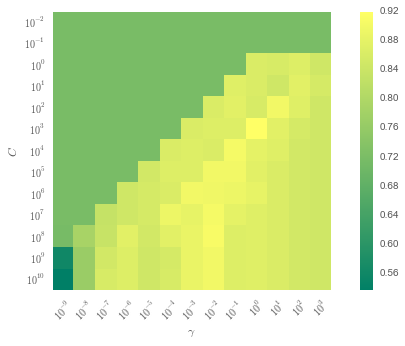

In [17]:
mclearn.classifier.grid_search_svm_rbf(X_scaled, y, train_size=50, test_size=50)

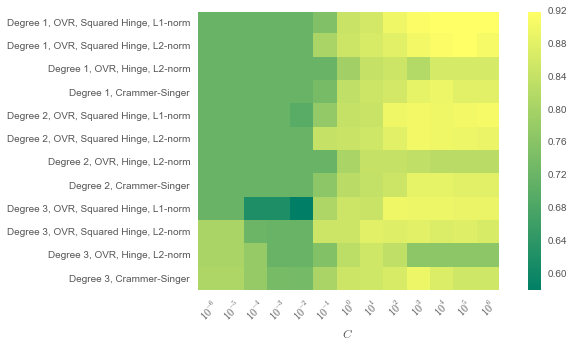

In [18]:
mclearn.classifier.grid_search_svm_poly(X_scaled, y, train_size=50, test_size=50)

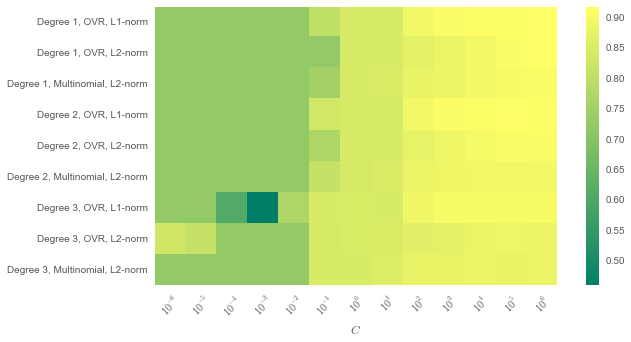

In [19]:
mclearn.classifier.grid_search_logistic(X_scaled, y, train_size=50, test_size=50)

Let's now compute some learning curves.

In [22]:
train_sizes = np.concatenate((np.arange(10, 100, 10), np.arange(100, 600, 100)))
test_sizes = [500] * 15

# initialise the classifiers
rbf_svm = SVC(kernel='rbf', gamma=1, C=1000, cache_size=200)
poly_svm = LinearSVC(C=10000, loss='squared_hinge', penalty='l1', dual=False, multi_class='ovr',
                         fit_intercept=True, random_state=21)
logistic = LogisticRegression(penalty='l1', dual=False, C=10000, multi_class='ovr', solver='liblinear', random_state=21)
forest = RandomForestClassifier(n_estimators=100, n_jobs=-1, class_weight='subsample', random_state=21)

# train the classifiers
lc_forest = mclearn.classifier.learning_curve(sdss, sfd98_features, target_col, forest, train_sizes,
            test_sizes, random_state=2, normalise=False, balanced=False, degree=1)

lc_rbf_svm = mclearn.classifier.learning_curve(sdss, sfd98_features, target_col, rbf_svm, train_sizes,
             test_sizes, random_state=2, normalise=True, balanced=False, degree=1)

lc_poly_svm_2 = mclearn.classifier.learning_curve(sdss, sfd98_features, target_col, poly_svm, train_sizes,
                test_sizes, random_state=2, normalise=True, balanced=False, degree=2)

lc_poly_svm_3 = mclearn.classifier.learning_curve(sdss, sfd98_features, target_col, poly_svm, train_sizes,
                test_sizes, random_state=2, normalise=True, balanced=False, degree=3)

lc_logistic_2 = mclearn.classifier.learning_curve(sdss, sfd98_features, target_col, logistic, train_sizes,
                test_sizes, random_state=2, normalise=True, balanced=False, degree=2)

lc_logistic_3 = mclearn.classifier.learning_curve(sdss, sfd98_features, target_col, logistic, train_sizes,
                test_sizes, random_state=2, normalise=True, balanced=False, degree=3)

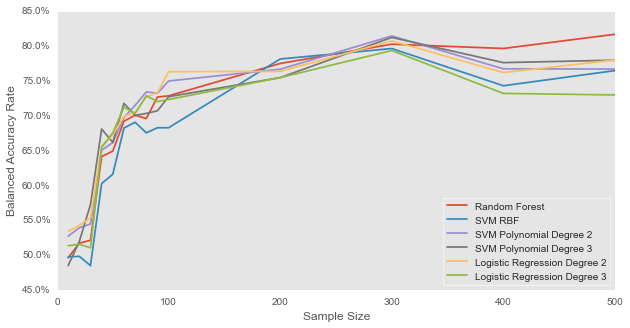

In [23]:
learning_curves = [lc_forest, lc_rbf_svm, lc_poly_svm_2, lc_poly_svm_3, lc_logistic_2, lc_logistic_3]

curve_labels = ['Random Forest', 'SVM RBF', 'SVM Polynomial Degree 2', 'SVM Polynomial Degree 3',
                'Logistic Regression Degree 2', 'Logistic Regression Degree 3']

fig = plt.figure(figsize=(10, 5))
ax = mclearn.viz.plot_learning_curve(train_sizes, learning_curves, curve_labels, xscale='linear')

## 5. Logistic Active Learning

Let's see if we can beat random sampling. The goal here is to get the best possible accuracy rate with the smallest possible training set. Thus we will need to be smart when choosing the next candidate to put in the training pool.

We start by training the logistic classifier with 20 random examples. Then each time we look at a random sample of the unlabelled pool and assign each example a score. We query the example with the best score and then train the classifier again. This is repeated until we have 1000 examples in the training set. Normally we should do around 10 trials and take the average, but in this notebook, let's just do 1 trial of the experiment.

Two uncertainty sampling heuristics are tested:

* Picking the candidate that displays the greatest Shannon entropy:

\begin{align}
-\sum_c q_c \log(q_c)
\end{align}

* Picking the candidate with the smallest margin:

\begin{align}
M_n = \left| p(c \mid \mathbf{x}_n) - p(c' \mid \mathbf{x}_n) \right|
\end{align}

And two query by bagging heuristics are tested:

* Picking the candidate with the smallest average margin.

* Picking the candidate with the largest value of the average Kullback-Leibler divergence from the average:
\begin{align}
	\dfrac{1}{B} \sum_{b=1}^B \text{KL}(f_b \mid\mid f_\text{avg})
\end{align}

Note that the KL divergence of $Q$ from $P$ is defined as

\begin{align}
	D_{\mathrm{KL}}(P\|Q) = \sum_i P(i) \, \ln\frac{P(i)}{Q(i)}.
\end{align}

This KL divergence measures the amount of information lost when $Q$ is used to approximate $P$. In the active learning context, $Q$ is the average prediction probability of the committee, while $P$ is the prediction of a particular committee member.

Okay, let's the run the experiments. This will take roughly 5 minutes to run.

In [24]:
# initialise the main classifier
logistic = LogisticRegression(multi_class='ovr', penalty='l1', C=10000, random_state=2, class_weight='auto')

# list of all heuristics to be used (and the paths where results are saved)
heuristics = [mclearn.heuristics.random_h, mclearn.heuristics.entropy_h, mclearn.heuristics.margin_h,
              mclearn.heuristics.qbb_margin_h, mclearn.heuristics.qbb_kl_h]

# set up the logistic committee
committee = []
committee_size = 3
for i in range(committee_size):
    member = LogisticRegression(multi_class='ovr', penalty='l1', C=10000, random_state=2, class_weight='auto')
    committee.append(member)
    
# 70/30 split of training and test sets
training_pool, testing_pool, training_oracle, testing_oracle = train_test_split(
    np.array(sdss[sfd98_features]), np.array(sdss[target_col]), train_size=0.7)

# shuffle and randomise data
training_pool, training_oracle = shuffle(training_pool, training_oracle, random_state=14)

# run active learning experiment for each heuristic
learning_curves = []
for heuristic in heuristics:
    lc = mclearn.active.run_active_learning_with_heuristic(heuristic, logistic, training_pool,
         testing_pool, training_oracle, testing_oracle, n_trials=1, full_sample_size=200, total_n=200,
         random_n=30, initial_n=20, bag_size=30, committee=committee, pickle_path=None, balanced_pool=False)
    learning_curves.append(lc)

..

..

..

..

..



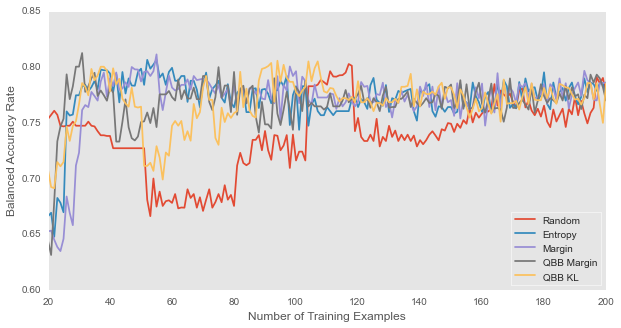

In [26]:
curve_labels = ['Random', 'Entropy', 'Margin', 'QBB Margin', 'QBB KL']
fig = plt.figure(figsize=(10, 5))
ax = mclearn.viz.plot_average_learning_curve(np.arange(20, 201), learning_curves, curve_labels)